In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(666)

In [2]:
%%time
df = pd.read_csv('4days.csv', parse_dates = ['time']).set_index('time')

Wall time: 12 ms


In [3]:
df.head()

,requests
time,
2021-03-18 00:10:00+00:00,541427
2021-03-18 00:20:00+00:00,531002
2021-03-18 00:30:00+00:00,571348
2021-03-18 00:40:00+00:00,550586
2021-03-18 00:50:00+00:00,535873


In [4]:
df.info(memory_usage='deep')
ts = df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 2021-03-18 00:10:00+00:00 to 2021-03-20 23:50:00+00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   requests  431 non-null    int64
dtypes: int64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='time'>

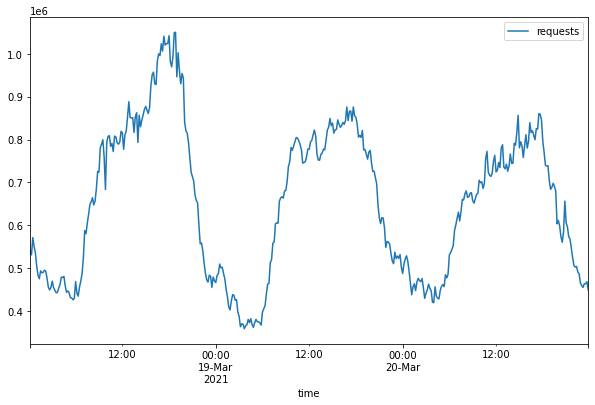

In [5]:
ts.plot(figsize=(10,6))

In [6]:
DF1 = df.loc['2021-03-18':'2021-03-19']
DF2 = df.loc['2021-03-19':'2021-03-20']
DF3 = df.loc['2021-03-20':'2021-03-21']

Построим скрипковую гистограмму

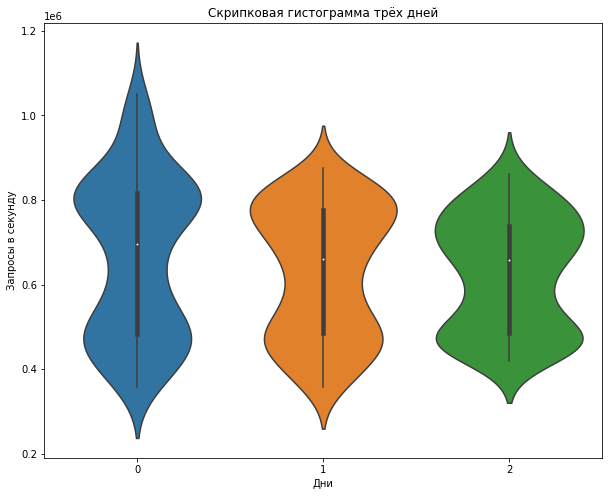

In [7]:
import seaborn as sns

fig = plt.subplots(figsize=(10, 8))

sns.violinplot( data = [DF1, DF2, DF3])
plt.title('Скрипковая гистограмма трёх дней')
plt.xlabel('Дни')
plt.ylabel('Запросы в секунду')
plt.show()

Из графика видно, что количество запросов с каждым днём снижалось

## Находим тренд с помощью скользящих средних функций

In [8]:
avg = ts.rolling(window=5).mean() # Скольщящее среднее

In [9]:
ewm = ts.ewm(alpha=0.1).mean() # Экспоненциальная скользящая средняя

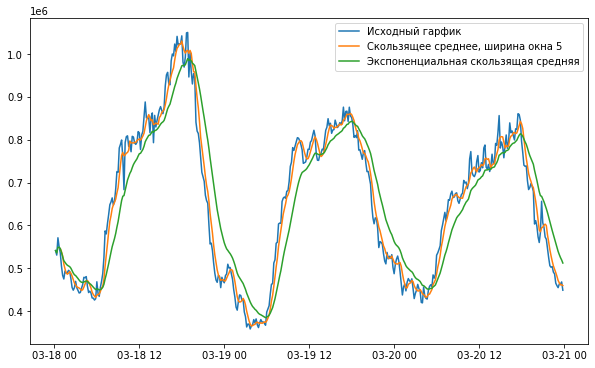

In [10]:
plt.figure(figsize=(10,6))
plt.plot(ts, label='Исходный гарфик')
plt.plot(avg, label='Скользящее среднее, ширина окна 5')
plt.plot(ewm, label='Экспоненциальная скользящая средняя')
plt.legend()
plt.show()

## Predict with `statsmodels`

In [11]:
#!pip3 install statsmodels

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
ts.index

DatetimeIndex(['2021-03-18 00:10:00+00:00', '2021-03-18 00:20:00+00:00',
               '2021-03-18 00:30:00+00:00', '2021-03-18 00:40:00+00:00',
               '2021-03-18 00:50:00+00:00', '2021-03-18 01:00:00+00:00',
               '2021-03-18 01:10:00+00:00', '2021-03-18 01:20:00+00:00',
               '2021-03-18 01:30:00+00:00', '2021-03-18 01:40:00+00:00',
               ...
               '2021-03-20 22:20:00+00:00', '2021-03-20 22:30:00+00:00',
               '2021-03-20 22:40:00+00:00', '2021-03-20 22:50:00+00:00',
               '2021-03-20 23:00:00+00:00', '2021-03-20 23:10:00+00:00',
               '2021-03-20 23:20:00+00:00', '2021-03-20 23:30:00+00:00',
               '2021-03-20 23:40:00+00:00', '2021-03-20 23:50:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=431, freq=None)

In [14]:
data = ts.asfreq(freq='600S')

In [15]:
data.isna().sum()

requests    0
dtype: int64

In [16]:
n = len(data)
train, test = data[:int(n*0.7)], data[int(n*0.7): ]

In [17]:
model = ExponentialSmoothing(train,
                             seasonal='Add',
                             seasonal_periods=24*6,
#                              initialization_method='estimated',
#                              use_boxcox=True
                            )

C:\Users\ПКК\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [18]:
fit = model.fit(optimized=True)

C:\Users\ПКК\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [19]:
pred = fit.predict(start=test.index[0], end=test.index[-1])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 2021-03-18 00:10:00+00:00 to 2021-03-20 23:50:00+00:00
Freq: 600S
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   requests  431 non-null    int64
dtypes: int64(1)
memory usage: 6.7 KB


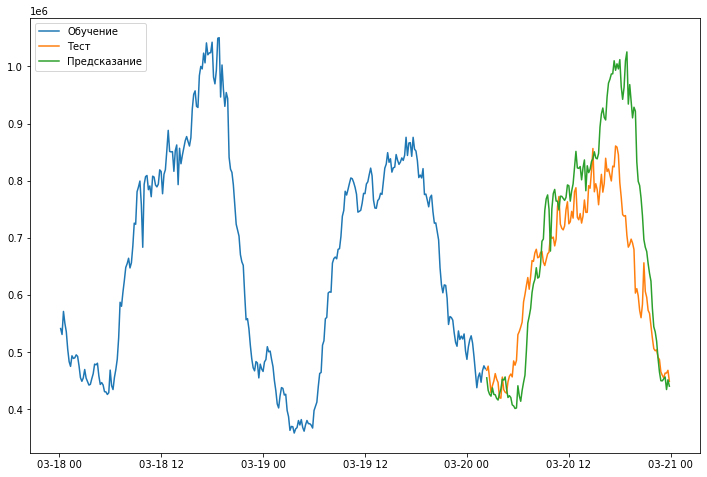

In [21]:
plt.figure(figsize=(12,8))
plt.plot(train, label='Обучение')
plt.plot(test, label='Тест')
plt.plot(pred, label='Предсказание')
plt.legend()
plt.show()

Предсказанные значения на тестовой выборке

In [22]:
pred

2021-03-20 02:20:00+00:00    455213.926158
2021-03-20 02:30:00+00:00    433302.308573
2021-03-20 02:40:00+00:00    426372.791612
2021-03-20 02:50:00+00:00    423122.525072
2021-03-20 03:00:00+00:00    437664.135766
                                 ...      
2021-03-20 23:10:00+00:00    453416.474930
2021-03-20 23:20:00+00:00    456781.067735
2021-03-20 23:30:00+00:00    434731.887887
2021-03-20 23:40:00+00:00    451797.328834
2021-03-20 23:50:00+00:00    440554.121726
Freq: 600S, Length: 130, dtype: float64

Проверим насколько точно модель предсказала трафик на тестовых данных

In [23]:
def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

print('Абсолютная средняя ошибка')
MAPE(test.values, pred.values)

Абсолютная средняя ошибка


33.707868244563386

Не самая лучшая точность.

# Попробуем предсказать трафик с помощью `AutoReg`

In [24]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

sel = ar_select_order(data, 15, seasonal=True, period = 24*6, old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               requests   No. Observations:                  431
Model:               Seas. AutoReg(2)   Log Likelihood               -4787.275
Method:               Conditional MLE   S.D. of innovations          16987.130
Date:                Mon, 10 May 2021   AIC                             20.166
Time:                        02:37:34   BIC                             21.557
Sample:                    03-18-2021   HQIC                            20.715
                         - 03-20-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.86e+04   1.41e+04      2.738      0.006     1.1e+04    6.62e+04
s(2,144)    -5941.6128    1.7e+04     -0.349      0.727   -3.93e+04    2.75e+04
s(3,144)     7407.1021   1.55e+04      0.477    

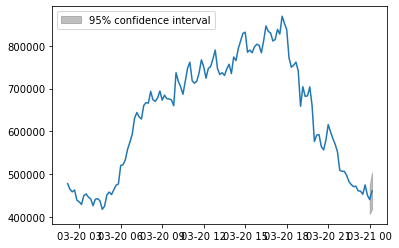

In [25]:
fig = res.plot_predict(300, len(data) + 1) # Предсказание на 10 минут

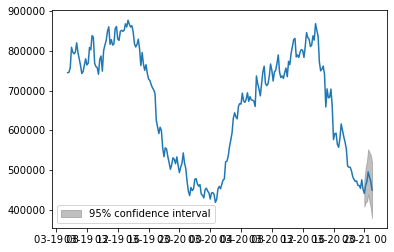

In [26]:
fig = res.plot_predict(200, len(data) + 6) # Предсказание на 1 час

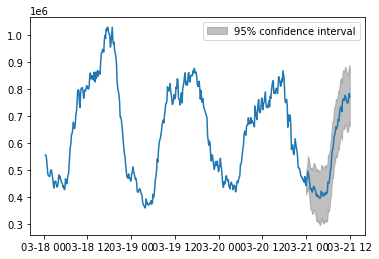

In [27]:
fig = res.plot_predict(0, len(data) + 6*12) # Предсказание на 12 часов

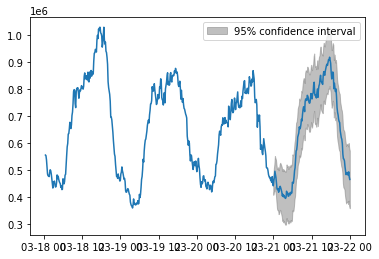

In [28]:
fig = res.plot_predict(0, len(data) + 6*24) # Предсказание на 24 часа

Так и не получилось найти точные значения предсказаний.

# Попробуем предсказать трафик с помощью `ARIMA` 

In [29]:
import pmdarima as pmd

Drata = data

train = Drata[:int(0.7*(len(Drata)))]
valid = Drata[int(0.7*(len(Drata))):]

arima_model = pmd.auto_arima(Drata, 
                              start_p=0,d = 1,start_q=0,
                              test="adf", supress_warnings = True,
                              trace=True)

#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9900.845, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9902.833, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9902.833, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9898.880, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9904.760, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.413 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  431
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4948.440
Date:                Mon, 10 May 2021   AIC                           9898.880
Time:                        02:37:37   BIC                           9902.944
Sample:                             0   HQIC                          9900.485
                                - 431                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.784e+08    2.6e+07     22.210      0.000    5.27e+08    6.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               119.37
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
valid['predicted'] = arima_model.predict(n_periods = len(valid))

def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

print('Абсолютная средняя ошибка')
MAPE(valid.requests, valid.predicted)

Абсолютная средняя ошибка


<ipython-input-30-3bd7f69354a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predicted'] = arima_model.predict(n_periods = len(valid))


27.206906150874083

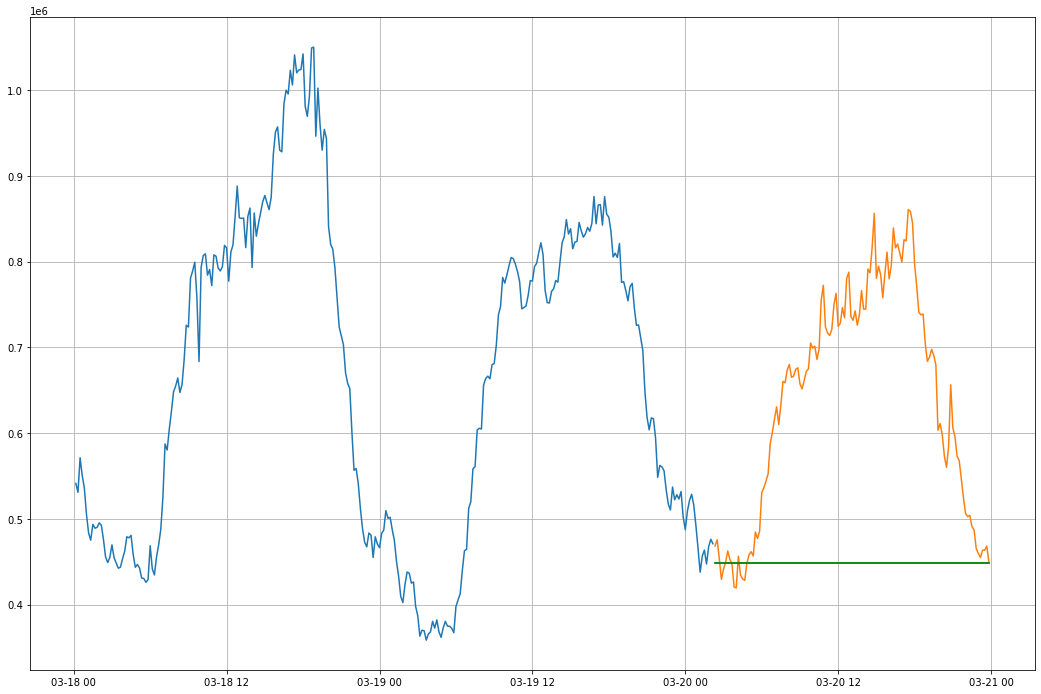

In [31]:
fig, ax1 = plt.subplots(1,figsize=(18,12))
ax1.plot(train)
ax1.plot(valid)
ax1.plot(valid.predicted, color = 'green')
ax1.grid()
plt.show()

Многое не получилось из-за того, что я не до конца разобрался с работой моделей и сезонностями.